# Plotting EUV Maps

In [2]:
import astropy.units as u
import datetime
import os
import numpy as np
from sunpy.net import Fido, attrs as a
import sunpy.map
import sys
import glob

import tools.chmap.utils as utils
from tools.chmap.prep import prep_aia_image
import tools.chmap.datatypes as datatypes
# import tools.chmap.ezseg.ezseg as ezsegwrapper
import tools.chmap.ezseg.ezsegwrapper as ezsegwrapper

ModuleNotFoundError: No module named 'tools.chmap.ezseg.ezseg'

In [2]:
ENC = 'E11'
center_date = datetime.datetime(year=2022, month=2, day=25)
euv_obs_cadence=12*u.hour
days_arnd = 10 # how many days in each direction from the center data do you want
EUV_DIR = f'/Users/tamarervin/Desktop/Research/mag_model/{ENC}/euv_data/'

## Download Files

In [ ]:
# download the necessary files -- for 48 files takes about 3 minutes

savepath = f"{EUV_DIR}/{center_date.strftime('%Y-%m-%d')}.fits"

sys.stdout.write(f"Searching for input EUV maps")
res=Fido.search(
    a.Time(center_date-datetime.timedelta(days=days_arnd), 
        center_date+datetime.timedelta(days=days_arnd)
    ), 
    a.Instrument.aia,
    a.Wavelength(193*u.angstrom), 
    a.Sample(euv_obs_cadence)
    )  
downloaded_files = Fido.fetch(res)


# Creating basic EUV map

In [3]:
# MAP PARAMETERS
x_range = [0, 2 * np.pi]
y_range = [-1, 1]
map_nycoord = 1600
del_y = (y_range[1] - y_range[0]) / (map_nycoord - 1)
map_nxcoord = (np.floor((x_range[1] - x_range[0]) / del_y) + 1).astype(int)
# generate map x,y grids. y grid centered on equator, x referenced from lon=0
map_y = np.linspace(y_range[0], y_range[1], map_nycoord, dtype='<f4')
map_x = np.linspace(x_range[0], x_range[1], map_nxcoord, dtype='<f4')

# MINIMUM MERGE MAPPING PARAMETERS
del_mu = None  # optional between this method and mu_merge_cutoff method
mu_cutoff = 0.0  # lower mu cutoff value
mu_merge_cutoff = 0.4  # mu cutoff in overlap areas


In [4]:
# pull the list of filenames
filenames = glob.glob(os.path.join(EUV_DIR, '*'))

In [5]:
# prep images for analysis
print('Prepping', len(filenames), 'images for merge mapping.')
maps = [prep_aia_image(sunpy.map.Map(m), deconvolve=False) for m in filenames]

Prepping 61 images for merge mapping.
  Prepping Image... done (0.85s)
  Prepping Image... done (0.82s)
  Prepping Image... done (0.82s)
  Prepping Image... done (0.82s)
  Prepping Image... done (0.82s)
  Prepping Image... done (0.82s)
  Prepping Image... done (0.83s)
  Prepping Image... done (0.82s)
  Prepping Image... done (0.82s)
  Prepping Image... done (0.83s)
  Prepping Image... done (0.82s)
  Prepping Image... done (0.81s)
  Prepping Image... done (0.82s)
  Prepping Image... done (0.83s)
  Prepping Image... done (0.82s)
  Prepping Image... done (0.83s)
  Prepping Image... done (0.81s)
  Prepping Image... done (0.82s)
  Prepping Image... done (0.82s)
  Prepping Image... done (0.82s)
  Prepping Image... done (0.84s)
  Prepping Image... done (0.82s)
  Prepping Image... done (0.82s)
  Prepping Image... done (0.84s)
  Prepping Image... done (0.85s)
  Prepping Image... done (0.83s)
  Prepping Image... done (0.83s)
  Prepping Image... done (0.85s)
  Prepping Image... done (0.84s)
  Pre

In [ ]:
# COMBINE MAPS
euv_combined = None
chd_combined = None
chd_map = None

for i, cr in enumerate(maps):
        euv_map = cr.interp_to_map(R0=1.01, map_x=map_x, map_y=map_y, image_num=i)
        euv_combined = utils.cr_map(euv_map, chd_map, euv_combined, chd_combined, n_images=i, mu_cutoff=0.0, mu_merge_cutoff=0.4)

# Plot combined map
utils.PlotMap(euv_combined, nfig='E11', title='Carrington Rotation Map (PSP E11)')

In [ ]:
# BUILDING CHD DETECTION
thresh1 = 0.95
thresh2 = 1.35
# consecutive pixel value
nc = 3
# maximum number of iterations
iters = 100
euv_combined = None
chd_combined = None
for i, los_image in enumerate(maps[0:20]):
    # define chd parameters
    los_image.get_coordinates()
    mu_array = los_image.mu
    data = los_image.data

    # get mu index locations where mu is valid.
    mu_indices = np.where(mu_array > 0)
    use_indices = np.logical_and(mu_array > 0., data > 2.)

    use_chd = use_indices.astype(int)
    use_chd = np.where(use_chd == 1, use_chd, los_image.no_data_val)
    nx = los_image.x.size
    ny = los_image.y.size

    # calculate new threshold parameters based off reference (AIA) instrument
    t1 = thresh1 # * ref_alpha + ref_x
    t2 = thresh2 # * ref_alpha + ref_x

    # fortran chd algorithm - from Sam's repository
    np.seterr(divide='ignore')
    # ezseg_output, iters_used = ezsegwrapper.ezseg(np.log10(image_data), use_chd, nx, ny, t1, t2, nc, iters)
    ezseg_output = ezsegwrapper.ezseg_algorithm(np.log10(data), use_chd, nx, ny, t1, t2, nc, iters)
    chd_result = np.logical_and(ezseg_output == 0, use_chd == 1)
    chd_result = chd_result.astype(int)

    # create CHD image
    chd_image = datatypes.create_chd_image(los_image, chd_result)
    chd_image.get_coordinates()

    # create EUV and CHD map
    euv_map = los_image.interp_to_map(R0=1.01, map_x=map_x, map_y=map_y, image_num=i)
    chd_map = chd_image.interp_to_map(R0=1.01, map_x=map_x, map_y=map_y, image_num=i)
    euv_map.chd = chd_map.data

    euv_combined = utils.cr_map(euv_map, chd_map, euv_combined, chd_combined, n_images=i, mu_cutoff=0.0, mu_merge_cutoff=0.4)


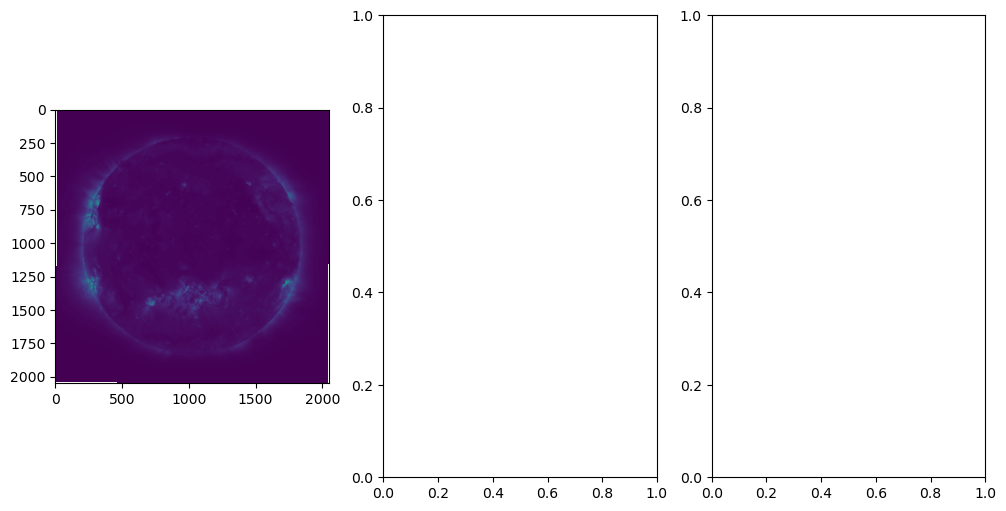

In [6]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=[12, 6])
axs[0].imshow(maps[0].data)
axs[1].imshow(euv_map.data)
axs[2].imshow(euv_combined.data)

In [ ]:
utils.PlotMap(euv_combined)

In [10]:
mp = maps[0]
valid_data = ~np.isnan(mp.data)
nc=3
iters=100
ezseg_output = ezsegwrapper.ezseg_algorithm(np.log10(mp.data), valid_data, mp.data.shape[0], mp.data.shape[1], 1.25, 1.75, nc, iters)

/var/folders/by/lx780c7j7w58m_tkpc3q83kc0000gn/T/ipykernel_4678/1804210777.py:5: RuntimeWarning: invalid value encountered in log10
  ezseg_output = ezsegwrapper.ezseg_algorithm(np.log10(mp.data), valid_data, mp.data.shape[0], mp.data.shape[1], 1.25, 1.75, nc, iters)


In [ ]:
ch_map_obs = sunpy.map.Map(np.invert(ezseg_output).astype(float),euv_map.meta)

/var/folders/by/lx780c7j7w58m_tkpc3q83kc0000gn/T/ipykernel_4678/3151275942.py:5: RuntimeWarning: invalid value encountered in log10
  axs[1].hist(np.log10(filtered_data), bins=50, color='thistle')
/var/folders/by/lx780c7j7w58m_tkpc3q83kc0000gn/T/ipykernel_4678/3151275942.py:7: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(filtered_data), bins=50)


(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        2.00000e+00, 3.00000e+00, 2.00000e+00, 1.00000e+00, 4.00000e+00,
        9.00000e+00, 1.40000e+01, 1.10000e+01, 2.30000e+01, 3.80000e+01,
        6.40000e+01, 1.01000e+02, 1.44000e+02, 2.63000e+02, 3.77000e+02,
        6.35000e+02, 9.70000e+02, 1.61700e+03, 2.60800e+03, 4.13400e+03,
        6.77100e+03, 1.07160e+04, 1.72220e+04, 2.55080e+04, 3.29400e+04,
        2.90580e+04, 1.63430e+04, 1.78700e+04, 2.88840e+04, 7.53710e+04,
        2.00047e+05, 2.16478e+05, 1.84223e+05, 2.01861e+05, 2.80914e+05,
        6.26542e+05, 7.10865e+05, 6.41128e+05, 3.63065e+05, 2.10958e+05,
        1.10417e+05, 5.39310e+04, 2.02700e+04, 2.63300e+03, 8.80000e+01]),
 array([-6.4676528 , -6.26657867, -6.06550503, -5.8644309 , -5.66335678,
        -5.46228266, -5.26120853, -5.06013489, -4.85906076, -4.65798664,
        -4.45691299, -4.25583887, -4.05476475, -3.85369062, -3.65261674,
        -3.45154285, -3.25046873, -3.04939461, -2

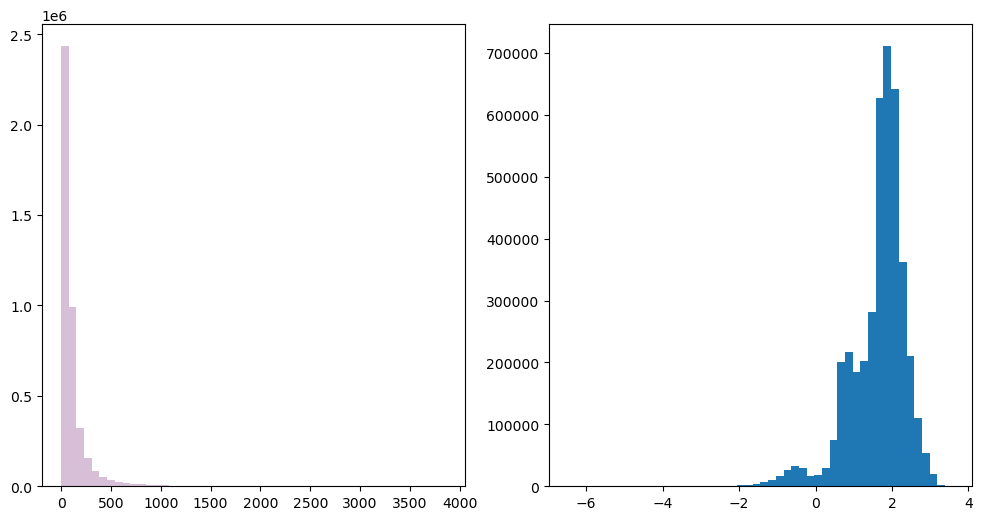

In [7]:
data = maps[0].data.flatten()
filtered_data = data[data != -9999]
fig, axs = plt.subplots(1, 2, figsize=[12, 6])
axs[0].hist(filtered_data, bins=50, color='thistle')
axs[1].hist(np.log10(filtered_data), bins=50, color='thistle')

plt.hist(np.log10(filtered_data), bins=50)

In [ ]:
plt.imshow(ezseg_output)